# Bayesian Geostatistical Models

Why using Bayesian
- Accounts autocorrelation, meaning that observations closer together in space are more likely to be similar by incorporating spatial correlation structures (e.g., Gaussian processes) into the model.

- Accounts non - linear relationships

- Uncertainty Quantification:

    Posterior Distributions: Bayesian models provide full posterior distributions for all model parameters and predictions, allowing for a thorough quantification of uncertainty. This is particularly important in spatial analysis, where predictions and parameter estimates can be highly uncertain due to limited or noisy data.

    Credible Intervals: Bayesian models provide credible intervals for predictions and parameters, which can be more informative than point estimates and confidence intervals from frequentist models.

- Prior Information:

    Incorporation of Expert Knowledge: Useful when dealing with sparse or noisy data. Priors can help stabilize estimates and improve predictions in areas with limited data.

    Regularization: Priors can act as regularizers, preventing overfitting and improving the robustness of the model.

    

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
#import xarray as xr
#import geopandas as gpd

from theano import tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(286)

WARN: Could not locate executable armflang


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


Running on PyMC3 v3.11.6


In [4]:
mobile_path = '/lirneasia/data/sei_mapping/raw/mobile_features.csv'
satellite_path = '/lirneasia/data/sei_mapping/raw/satellite_features.csv'
pca_path = '/lirneasia/data/sei_mapping/raw/pca_census.csv'
gt_path = '/lirneasia/data/sei_mapping/processed/dsd_to_gnd_ground_truth.csv'

#Reading Ground truth DATA and filtering zero population gnds (Grama niladhari divisions are referred to as gnd, which are the smallest diviions in Sri Lanka)
data_pca = pd.read_csv(pca_path)
missing_gnd_ids = data_pca.loc[data_pca['PC1'].isnull(), 'gnd_id']
count = missing_gnd_ids.count()
print('No of gnds with zero population:',count)

# Read the datasets and merge into a single pandas dataframe
data_raw = pd.read_csv(mobile_path).merge(pd.read_csv(satellite_path), on='gnd_id').merge(pd.read_csv(pca_path), on='gnd_id').rename(columns={"PC1": "pc_1"}).set_index('gnd_id')

#Removing the zero population gnds from the dataframe
data_raw = data_raw[~data_raw.index.isin(missing_gnd_ids)]

# Log transform skewed variables
data_unskewed = data_raw[[

    #Call detail records
    "call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",

    #Remote Sensing data
    "travel_time_major_cities",
    "population_count_worldpop",
    "population_count_ciesin",
    "population_density",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk",
    "distance_roadways_primary",
    "distance_roadways_secondary",
    "distance_roadways_tertiary",
    "distance_waterways",
    "urban_rural_fb",
    "urban_rural_ciesin",
    "global_human_settlement",
    "protected_areas",
    "land_cover_woodland",
    "land_cover_grassland",
    "land_cover_cropland",
    "land_cover_wetland",
    "land_cover_bareland",
    "land_cover_urban",
    "land_cover_water",
    "pregnancies",
    "births",
    "precipitation",
    "temperature",

    #principle componanet analysis
    "pc_1"
]].copy()

# Log transform skewed variables
data_unskewed.loc[:, "radius_of_gyration_log"] = np.log(data_unskewed["radius_of_gyration"])
data_unskewed.loc[:, "travel_time_major_cities_log"] = np.log(data_unskewed["travel_time_major_cities"] + 1)
data_unskewed.loc[:, "population_count_worldpop_log"] = np.log(data_unskewed["population_count_worldpop"] + 1)
data_unskewed.loc[:, "population_count_ciesin_log"] = np.log(data_unskewed["population_count_ciesin"] + 1)
data_unskewed.loc[:, "population_density_log"] = np.log(data_unskewed["population_density"])
data_unskewed.loc[:, "elevation_log"] = np.log(data_unskewed["elevation"] + 1)
data_unskewed.loc[:, "distance_roadways_trunk_log"] = np.log(data_unskewed["distance_roadways_trunk"] + 1)
data_unskewed.loc[:, "distance_roadways_primary_log"] = np.log(data_unskewed["distance_roadways_primary"] + 1)
data_unskewed.loc[:, "distance_roadways_secondary_log"] = np.log(data_unskewed["distance_roadways_secondary"] + 1)
data_unskewed.loc[:, "distance_roadways_tertiary_log"] = np.log(data_unskewed["distance_roadways_tertiary"] + 1)
data_unskewed.loc[:, "distance_waterways_log"] = np.log(data_unskewed["distance_waterways"] + 1)
data_unskewed.loc[:, "urban_rural_fb_log"] = np.log(data_unskewed["urban_rural_fb"] + 1)
data_unskewed.loc[:, "global_human_settlement_log"] = np.log(data_unskewed["global_human_settlement"] + 1)
data_unskewed.loc[:, "protected_areas_log"] = np.log(data_unskewed["protected_areas"] + 1)
data_unskewed.loc[:, "land_cover_grassland_log"] = np.log(data_unskewed["land_cover_grassland"] + 1)
data_unskewed.loc[:, "land_cover_wetland_log"] = np.log(data_unskewed["land_cover_wetland"] + 1)
data_unskewed.loc[:, "land_cover_bareland_log"] = np.log(data_unskewed["land_cover_bareland"] + 1)
data_unskewed.loc[:, "land_cover_water_log"] = np.log(data_unskewed["land_cover_water"] + 1)
data_unskewed.loc[:, "pregnancies_log"] = np.log(data_unskewed["pregnancies"])
data_unskewed.loc[:, "births_log"] = np.log(data_unskewed["births"])


#Optional step, consider rs_only variable when conducting the study only with remote sensing data
rs_only = data_unskewed[[
    "travel_time_major_cities_log",
    "population_count_worldpop_log",
    "population_count_ciesin_log",
    "population_density_log",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation_log",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk_log",
    "distance_roadways_primary_log",
    "distance_roadways_secondary_log",
    "distance_roadways_tertiary_log",
    "distance_waterways_log",
    "urban_rural_fb_log",
    "urban_rural_ciesin",
    "global_human_settlement_log",
    "protected_areas_log",
    "land_cover_woodland",
    "land_cover_grassland_log",
    "land_cover_cropland",
    "land_cover_wetland_log",
    "land_cover_bareland_log",
    "land_cover_urban",
    "land_cover_water_log",
    "pregnancies_log",
    "births_log",
    "precipitation",
    "temperature",

    #principle componanet analysis
    "pc_1"
]].copy()

#Optional step, consider cdr_only variable when conducting the study only with call detail records

cdr_only = data_unskewed[[
    "call_count",
    "radius_of_gyration_log",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",
    #principle componanet analysis
    "pc_1" 
]].copy()

#data_unskewed = cdr_only.copy()


No of gnds with zero population: 37


In [5]:

#uncomment and run the below when you are running for a model with RS + CDR

data_unskewed = data_unskewed.drop(columns=["radius_of_gyration", "travel_time_major_cities", "population_count_worldpop", "population_count_ciesin", "population_density", "elevation", "distance_roadways_trunk", "distance_roadways_primary", "distance_roadways_secondary", "distance_roadways_tertiary", "distance_waterways", "urban_rural_fb", "global_human_settlement", "protected_areas", "land_cover_grassland", "land_cover_wetland", "land_cover_bareland", "land_cover_water", "pregnancies", "births"])

#fill missing values with their mean
data_unskewed.fillna(data_unskewed.mean(), inplace=True)
data_unskewed.isna().sum()

az.style.use("arviz-darkgrid")

data_unskewed.columns = data_unskewed.columns.map(str.strip)

data_b = data_unskewed.copy()

# Styling using arviz-darkgrid
az.style.use("arviz-darkgrid")

In [6]:
#Dont run this cell when you want the model for the whole country

gnd_ur = pd.read_csv("/home/manifold/Desktop/DAP/rs+cdr_poverty_mapping/Data/GND_urban_rural_classification.csv")

data_b = data_b.merge(gnd_ur, left_on =data_b.index, right_on = 'gnd_id', how= 'inner')


# Change accordingly
data_b = data_b[data_b.urbanity == 'Urban'].copy()
data_b = data_b.drop(columns=["urbanity"])


In [7]:
X = data_b.astype(float)
y = X.pop("pc_1")

'''
In Bayesian analysis, standardization of features (subtracting the mean and dividing by the standard deviation)
is often performed to ensure that all features contribute equally to the model without any one feature dominating due to its scale.
'''

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape 

#N - number of raws
#D - number of features

There are a number of approaches for conducting variable selection, but a popular automated method is regularization, whereby ineffective covariates are shrunk towards zero via regularization (a form of penalization) if they do not contribute to predicting outcomes.

In the Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the hierarchical regularized horseshoe, which uses two regularization strategies, one global and a set of local parameters, one for each coefficient. The key to making this work is by selecting a long-tailed distribution as the shrinkage priors, which allows some to be nonzero, while pushing the rest towards zero.

In [8]:
D0 = int(D / 2) 
#taking half of the features

- Prior distribution reflects what you believe about parameters before seeing the data.
- Posterior distribution reflects what you believe about parameters after seeing the data, combining prior beliefs with the evidence from the data.

In [9]:
import theano.tensor as T

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    
    # Shrunken coefficients using Theano's tensor operations
    beta = pm.Deterministic(
        "beta", z * tau * lam * T.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + T.dot(T.as_tensor_variable(X.values), beta), sigma, observed=y.values)

z = pm.Normal("z", 0.0, 1.0, dims="predictors"): Defines a normal distribution for z with mean 0 and standard deviation 1 across predictors.

beta = pm.Deterministic("beta", z * tau * lam * T.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"): Calculates shrunken coefficients (beta) using Theano's tensor operations, incorporating z, tau, lam, and c2.


In [ ]:
pm.model_to_graphviz(test_score_model)

In [11]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Purpose:

    Prior Predictive Distribution: This distribution represents the range of possible outcomes for the data, assuming only the prior knowledge encoded in the model's prior distributions. It helps understand what kind of data the model would produce without any observed data influencing it.
    Generating Samples: By calling pm.sample_prior_predictive(100), you generate 100 sets of simulated data points based on the model's prior distributions. These samples are useful for understanding the variability and structure imposed by the model's prior assumptions.


In [12]:
Sampling: [beta0, c2, lam, scores, sigma, tau, z]

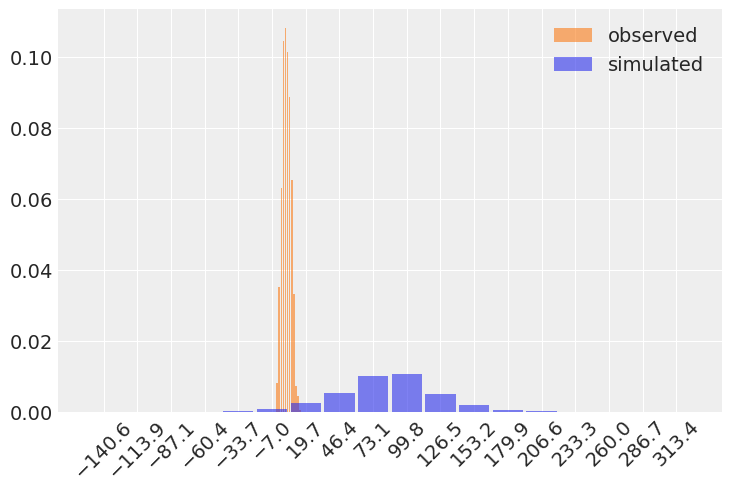

In [14]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

az.plot_dist(
    #data_unskewed["pc_1"].values,
    y,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)

# Plot prior predictive distribution for the "scores" variable
az.plot_dist(
    prior_samples["scores"], 
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)

plt.xticks(rotation=45)
plt.legend()
plt.show()


In [13]:
#this cell will run alonger period of time, depending on the size of the dataset

with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, z, c2, lam, tau, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1830 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


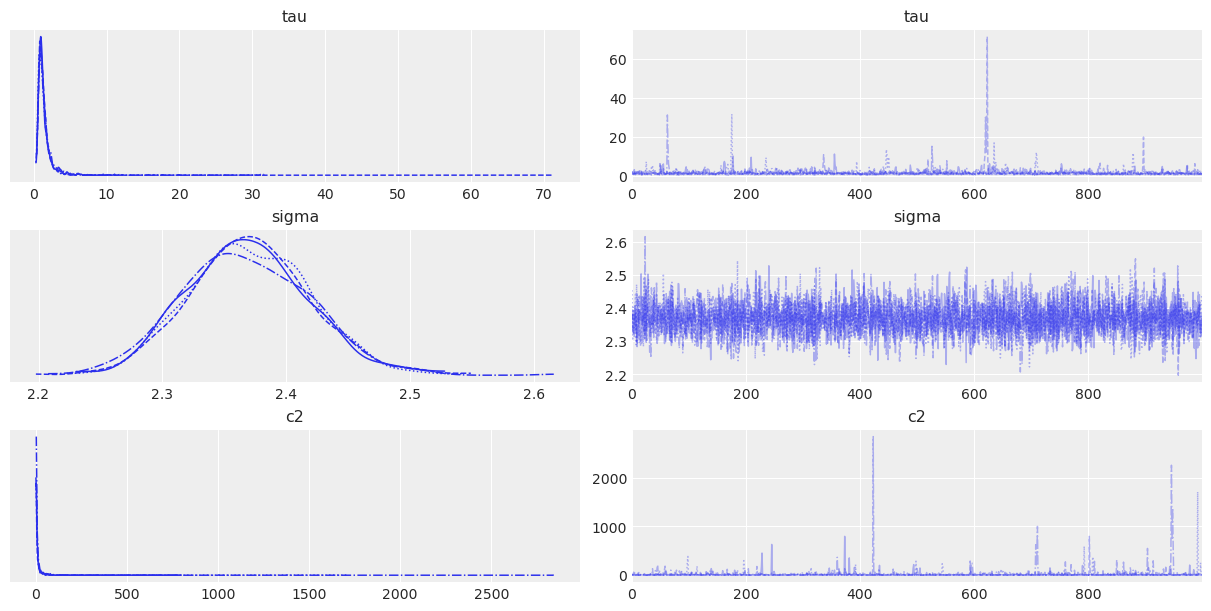

In [14]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]); 


Got error No model on context stack. trying to find log_likelihood in translation.


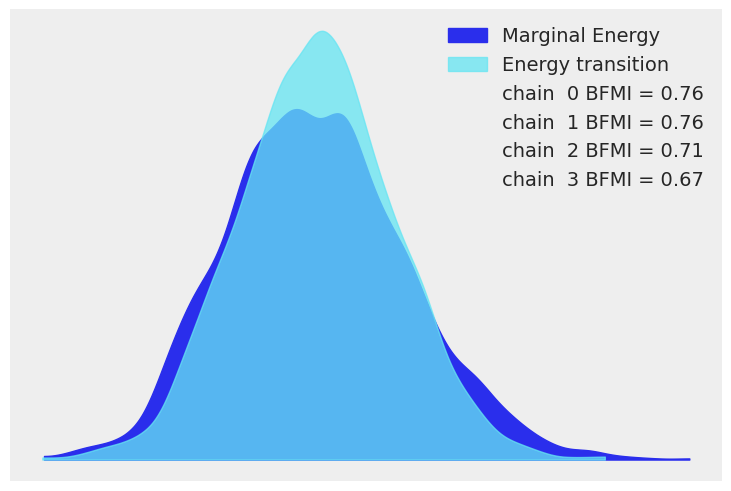

In [15]:
az.plot_energy(idata);

Got error No model on context stack. trying to find log_likelihood in translation.


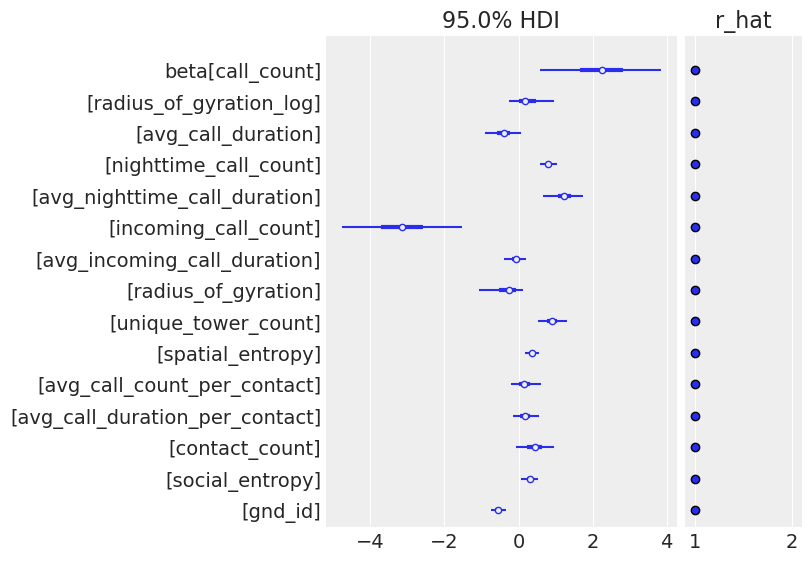

In [18]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [19]:
# Generate posterior predictive samples
with test_score_model:
    pp_samples = pm.sample_posterior_predictive(idata)

# Extract predicted values
pred_values = pp_samples["scores"].mean(axis=0)  # Taking mean as the prediction

# Append predicted values to data_b
data_b["pred_values"] = pred_values

In [22]:
data_b.to_csv("bayesian_results_final_Urban_rs_only.csv")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = data_b['pc_1']
y_pred = data_b['pred_values']

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R-squared Value:', r2)